In [7]:
from importlib import reload
from tfoptym.mathops import set_backend_to_jax,compute_eigenvalues_2x2
from tfoptym.thinfilms import compute_thin_films_byu, compute_thin_films_broadcasted
import jax.numpy as np
from astropy.io import fits

# make pretty pictures
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [2]:
# set backend shim
set_backend_to_jax()

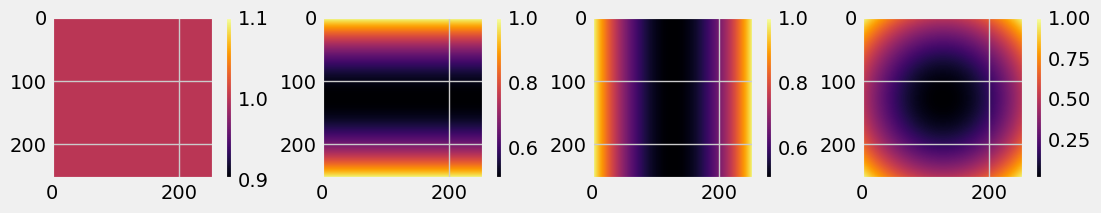

In [43]:
# Try the polynomial computation
from tfoptym.polynomials import gen_positive_polynomial_basis
basis = gen_positive_polynomial_basis(nterms=4)

plt.figure(figsize=[15,2])
for i,func in enumerate(basis):
    plt.subplot(1,len(basis)+1,i+1)
    plt.imshow(np.abs(func),cmap='inferno')
    plt.colorbar()
plt.subplots_adjust()
plt.show()

In [48]:
import tfoptym.thinfilms
reload(tfoptym.thinfilms)

def compute_diattenuation_retardance_transmission(jones):

    e1,e2 = compute_eigenvalues_2x2(jones)
    T = (np.abs(e1)**2 +np.abs(e2)**2)
    D = (np.abs(e1)**2 - np.abs(e2)**2) / T
    R = np.angle(e1) - np.angle(e2)

    return D,R,T

    

def cost_function(a,jones,basis,aoi,wavelength,indices,return_jones=False):
    """the function to differentiate with respect to the coefficient vector

    Parameters
    ----------
    a : 1D numpy.ndarray
        vector to pass to scipy.optimize.minimize. Is necesarilly a vector, but will
        be reshaped into an array of shape [nlayers,nmodes].

    jones : numpy array of shape N,N,npix,npix
        jones pupil to optimize

    basis : list of numpy arrays
        list of arrays representing the fundamental shapes of our film thickness basis

    aoi : float
        angle of incidence, radians, on the thin film stack

    wavelength : float
        wavelength of light to trace

    indices : list of floats
        stack of [n1,n2,n3,n4] containing refractive index information


    Returns
    -------
    cost
    """

    # figure out what shape a needs to be and reshape
    nmodes = len(basis)
    nlayers = int(a.shape[0]/nmodes)
    a = a.reshape([nlayers,nmodes])

    # create the film thicknesses
    film_thickness = np.zeros(basis[0].shape)
    thickness_list = []

    # add basis layers
    for layer in range(nlayers):

        for i,mode in enumerate(basis):
            film_thickness = film_thickness + a[layer,i]*mode

        thickness_list.append(film_thickness)
        film_thickness = np.zeros(basis[0].shape)

    # construct the stack
    stack = []
    for n,d in zip(indices,thickness_list):
        stack.append((n,d))

    # compute Fresnel coefficients
    fs,_ = compute_thin_films_broadcasted(stack, aoi, wavelength, ambient_index=1, substrate_index=1.5, polarization='s')
    fp,_ = compute_thin_films_broadcasted(stack, aoi, wavelength, ambient_index=1, substrate_index=1.5, polarization='s')

    # for data in [fs,fp]:
    #     plt.figure()
    #     plt.imshow(np.abs(data))
    #     plt.colorbar()
    #     plt.show()

    # store in thin film jones pupil
    thin_jones = np.zeros_like(jones)

    # accomodate for a jax quirk
    if np.__name__ == 'jax.numpy':
        thin_jones = thin_jones.at[...,0,0].set(fs)
        thin_jones = thin_jones.at[...,1,1].set(fp)
    else:
        thin_jones[...,0,0] = fs
        thin_jones[...,1,1] = fp

    total_jones = thin_jones @ jones

    D,R,T = compute_diattenuation_retardance_transmission(total_jones)
    # for data in [D,R,T]:
    #     plt.figure()
    #     plt.imshow(data)
    #     plt.show()

    cost = np.sqrt(np.var(D) + np.var(R) + np.sum(T)**2)

    if return_jones:
        return cost,total_jones
    else:
        return cost

a = np.zeros([3,4]) + 1e-10
n_list = [
    2,
    1 + 1j*7,
    1.2
]
aoi = np.pi/4
wvl = 1e-6
basis = gen_positive_polynomial_basis(nterms=4,npix=256)
# jones = np.ones([64,64,2,2],dtype=np.complex128)
cost_function(a.ravel(),jones,basis,aoi,wvl,n_list)

Array(11712.74318489, dtype=float64)

In [49]:
def load_jones_pupil(pth):
  """Loads Jones Pupils from FITS file

  Parameters
  ----------
  pth : pth
    path to fits file containing a real N x 2 x 2 array corresponding to the real
    or imaginary part of the jones pupil
  """
  return fits.getdata(pth)

datapth = 'test_data/'

Exxr = load_jones_pupil(datapth+'ELT_Exxr_V.fits')
Exxi = load_jones_pupil(datapth+'ELT_Exxi_V.fits')
Exyr = load_jones_pupil(datapth+'ELT_Exyr_V.fits')
Exyi = load_jones_pupil(datapth+'ELT_Exyi_V.fits')
Eyxr = load_jones_pupil(datapth+'ELT_Eyxr_V.fits')
Eyxi = load_jones_pupil(datapth+'ELT_Eyxi_V.fits')
Eyyr = load_jones_pupil(datapth+'ELT_Eyyr_V.fits')
Eyyi = load_jones_pupil(datapth+'ELT_Eyyi_V.fits')

# Jax sharp bits for array assignment
jones = np.zeros([256,256,2,2],dtype=np.complex128)
if np.__name__ == 'jax.numpy':
  print('using jax to set jones array')
  jones = jones.at[...,0,0].set(Exxr + 1j*Exxi)
  jones = jones.at[...,0,1].set(Exyr + 1j*Exyi)
  jones = jones.at[...,1,0].set(Eyxr + 1j*Eyxi)
  jones = jones.at[...,1,1].set(Eyyr + 1j*Eyyi)
else:
  jones[...,0,0] = Exxr + 1j*Exxi
  jones[...,0,1] = Exyr + 1j*Exyi
  jones[...,1,0] = Eyxr + 1j*Eyxi
  jones[...,1,1] = Eyyr + 1j*Eyyi

using jax to set jones array


In [46]:
def plot_jones_at(jones,index,operator=np.abs):
    if index == 'xx':
        i,j = 0,0
    elif index == 'xy':
        i,j = 0,1
    elif index == 'yx':
        i,j = 1,0
    elif index == 'yy':
        i,j = 1,1
    else:
        print('index not valid, defaulting to xx')
        i,j = 0,0

    if operator == np.abs:
        cmap = 'inferno'
    elif operator == np.angle:
        cmap = 'RdBu'
    elif operator == np.real:
        cmap = 'viridis'
    elif operator == np.imag:
        cmap = 'plasma'

    plt.figure()
    plt.imshow(operator(jones[...,i,j]),cmap=cmap)
    plt.colorbar()
    plt.show()

In [50]:
# attempt to use scipy.optimize
from jax.scipy.optimize import minimize
results = minimize(cost_function,a.ravel(),args=(jones,basis,aoi,wvl,n_list),method='BFGS')


In [51]:
# Jaren is sad
a_end = results.x.reshape([3,4])


Array([1.e-10, 1.e-10, 1.e-10, 1.e-10, 1.e-10, 1.e-10, 1.e-10, 1.e-10,
       1.e-10, 1.e-10, 1.e-10, 1.e-10], dtype=float64)